### TYK2 Partial Loss-of-Function

#### Full Length Partial LoF

We regenerated summary statistics using the stop aggregation model (where all stops are considered within each chunk as their own "position", and compared to all WT). Plotting all variants along the x-axis is very visually cluttered, but scatter plots of the Z-statsistics between mutant effects relative to WT and relative to aggregated Stop provide a way to quickly see the trends:

In [3]:
library(ggpubr)
library(knitr)
library(fs)
library(patchwork)
library(venn)
library(kableExtra)
library(tidyverse)

In [ ]:
sumstats <- sumstats <- dir_ls(path = "../sumstats/", regexp = "tyk2_.*combined.sumstats.tsv") %>%
    map_dfr(read_tsv, col_types = c("ncccnnnnnc")) %>%
    filter(grepl("aa",term), pos != 1188) %>%
    separate(term, c("condition", "aa"), ":") %>%
    mutate(condition = gsub("condition", "", condition),
           group = if_else(aa %in% c("mut_aa*", "mut_aaX"), chunk, "Non-Stop"),
           aa = gsub("mut_aa", "", aa),
           aa = if_else(aa %in% c("*","X"), "*", aa))

compute_difference <- function(test, control, sumstats) {
    
    df1 <- sumstats %>% filter(condition == test) %>% select(-condition)
    df2 <- sumstats %>% filter(condition == control) %>% select(-condition)
    
    df <- inner_join(df1, df2,
                     by = c("pos", "clone", "chunk", "aa", "version", "dispersion"))
    
    new_stats <- df %>%
        mutate(estimate = estimate.x - estimate.y,
               std.error = sqrt(std.error.x^2 + std.error.y^2)) %>%
        select(pos, clone, chunk, aa, estimate, std.error, dispersion, version) %>%
        ungroup()
    
    new_stats$condition = paste0(test, " - ", control)
    
    return(new_stats)
    
}

conditions <- unique(sumstats$condition)
noneIdx <- which(conditions == "None0")
ifnbIdx <- which(conditions == "IFNbeta100")

sumstats_none_contr <- map_dfr(conditions[-noneIdx],
                         ~compute_difference(test = .,
                                            control = "None0",
                                            sumstats = sumstats)) %>%
    mutate(condition = factor(condition,
                              levels = c("IFNbeta100 - None0",
                                         "IFNalpha1 - None0",
                                         "IFNalpha10 - None0",
                                         "IFNalpha100 - None0",
                                         "IFNalphaWithDrug100 - None0")))
sumstats_ifnb_contr <- map_dfr(conditions[-ifnbIdx],
                         ~compute_difference(test = .,
                                            control = "IFNbeta100",
                                            sumstats = sumstats)) %>%
    mutate(condition = factor(condition,
                              levels = c("None0 - IFNbeta100",
                                         "IFNalpha1 - IFNbeta100",
                                         "IFNalpha10 - IFNbeta100",
                                         "IFNalpha100 - IFNbeta100",
                                         "IFNalphaWithDrug100 - IFNbeta100")))

sumstats_all <- bind_rows(sumstats_none_contr, sumstats_ifnb_contr) %>%
    mutate(statistic = estimate / std.error,
           p.value = pmin(pnorm(statistic, mean = 0, sd = 1)*2,
                                 (1-pnorm(statistic, sd = 1))*2),
           p.adj = p.adjust(p.value, method = "BH"))

sumstats_all %>%
    mutate(estimate = estimate / log(2),
           std.error = std.error / log(2)) %>%
    rename("log2FoldChange" = "estimate") %>%
    write_tsv("../sumstats//tyk2_full_comparisons_stopagg.tsv")

In [35]:
sumstats <- read_tsv("../sumstats//tyk2_full_comparisons_stopagg.tsv") %>%
    mutate(condition = factor(condition,
                              levels = c("IFNbeta100 - None0",
                                         "IFNalpha1 - None0",
                                         "IFNalpha10 - None0",
                                         "IFNalpha100 - None0",
                                         "IFNalphaWithDrug100 - None0",
                                         "None0 - IFNbeta100",
                                         "IFNalpha1 - IFNbeta100",
                                         "IFNalpha10 - IFNbeta100",
                                         "IFNalpha100 - IFNbeta100",
                                         "IFNalphaWithDrug100 - IFNbeta100")))

stop_effects <- sumstats %>%
    ungroup() %>%
    filter(pos=="-1") %>%
    select(-pos, -aa)

Rows: 224830 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (5): clone, chunk, aa, version, condition
dbl (7): pos, log2FoldChange, std.error, dispersion, statistic, p.value, p.adj

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [36]:
sumstats_join <- inner_join(sumstats %>% filter(pos != -1),
                            stop_effects,
                            by = c("clone", "chunk", "version", "condition")) %>%
    mutate(log2FoldChange = log2FoldChange.x - log2FoldChange.y,
           std.error = sqrt(std.error.x^2 + std.error.y^2),
           statistic = log2FoldChange/std.error,
           p.value = pmin(pnorm(statistic, mean = 0, sd = 1)*2,
                                 (1-pnorm(statistic, sd = 1))*2),
           p.adj = p.adjust(p.value, method = "BH"),
           sig = if_else(p.adj < 0.01 & p.adj.x < 0.01 &
                         statistic.x < 0 & statistic > 0, "sig", "nonsig"))

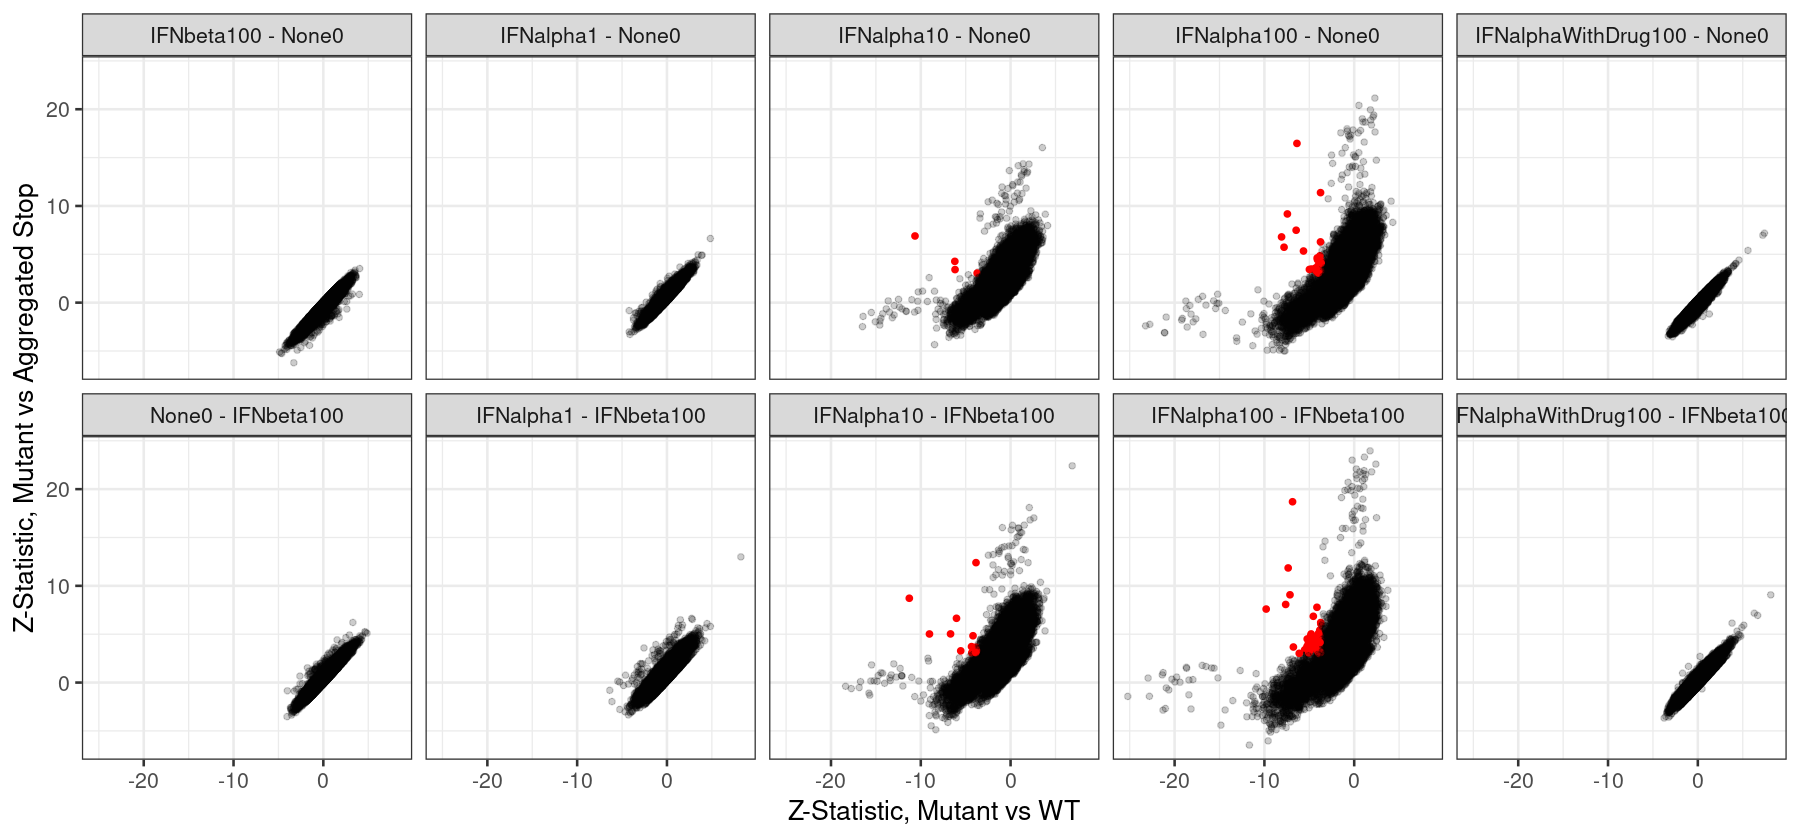

In [37]:
options(repr.plot.width = 15, repr.plot.height = 7)
ggplot(sumstats_join) +
    geom_point(aes(x = statistic.x, y = statistic,
                   color = if_else(sig == "sig", "red", "black"),
                   alpha = if_else(sig == "sig", 1, 0.2))) +
    theme_bw(base_size = 16) +
    facet_wrap(~condition, nrow = 2) +
    scale_color_identity() +
    scale_alpha_identity() +
    xlab("Z-Statistic, Mutant vs WT") + ylab("Z-Statistic, Mutant vs Aggregated Stop")

Counting up the number of partial LoF (red points) in each condition, we find:

In [98]:
sumstats_join %>%
    filter(sig == "sig") %>%
    count(condition) %>%
    rename("partial LoF" = "n") %>%
    kable("markdown")

sumstats_join %>%
    select(pos, clone, chunk, aa, condition,
           log2FoldChange.x, std.error.x, statistic.x, p.value.x, p.adj.x,
           log2FoldChange, std.error, statistic, p.value, p.adj) %>%
    rename("log2FoldChange_MutVsWt" = "log2FoldChange.x",
           "std.error_MutVsWt" = "std.error.x",
           "statistic_MutVsWt" = "statistic.x",
           "p.value_MutVsWt" = "p.value.x",
           "p.adj_MutVsWt" = "p.adj.x",
           "log2FoldChange_MutVsStop" = "log2FoldChange",
           "std.error_MutVsStop" = "std.error",
           "statistic_MutVsStop" = "statistic",
           "p.value_MutVsStop" = "p.value",
           "p.adj_MutVsStop"= "p.adj") %>%
    write_tsv("../sumstats/tyk2_full_comparisons_stopagg_partialLoF.tsv")

sumstats_join %>%
    select(pos, clone, chunk, aa, condition,
           log2FoldChange.x, std.error.x, statistic.x, p.value.x, p.adj.x,
           log2FoldChange, std.error, statistic, p.value, p.adj) %>%
    rename("log2FoldChange_MutVsWt" = "log2FoldChange.x",
           "std.error_MutVsWt" = "std.error.x",
           "statistic_MutVsWt" = "statistic.x",
           "p.value_MutVsWt" = "p.value.x",
           "p.adj_MutVsWt" = "p.adj.x",
           "log2FoldChange_MutVsStop" = "log2FoldChange",
           "std.error_MutVsStop" = "std.error",
           "statistic_MutVsStop" = "statistic",
           "p.value_MutVsStop" = "p.value",
           "p.adj_MutVsStop"= "p.adj") %>%
    filter(p.adj_MutVsStop < 0.01,
           p.adj_MutVsWt < 0.01,
           log2FoldChange_MutVsWt < 0,
           log2FoldChange_MutVsStop > 0,
           aa != "*") %>%
    write_tsv("../sumstats/tyk2_full_comparisons_stopagg_partialLoF_sigOnly.tsv")



|condition                | partial LoF|
|:------------------------|-----------:|
|IFNalpha10 - None0       |           4|
|IFNalpha100 - None0      |          37|
|IFNalpha10 - IFNbeta100  |          16|
|IFNalpha100 - IFNbeta100 |          74|

In contrast, we have the following total counts for LoF variants per comparison:

In [87]:
read_tsv("../sumstats/tyk2_full_comparisons.tsv", show_col_types = FALSE) %>%
    filter(p.adj < 0.01, log2FoldChange < 0, aa != "*") %>%
    count(condition) %>%
    rename("total LoF" = "n") %>%
    kable("markdown")



|condition                        | total LoF|
|:--------------------------------|---------:|
|IFNalpha1 - IFNbeta100           |        53|
|IFNalpha1 - None0                |         9|
|IFNalpha10 - IFNbeta100          |      1665|
|IFNalpha10 - None0               |      1439|
|IFNalpha100 - IFNbeta100         |      1686|
|IFNalpha100 - None0              |      1569|
|IFNalphaWithDrug100 - IFNbeta100 |         2|
|IFNbeta100 - None0               |        33|
|None0 - IFNbeta100               |         8|

Let's look at the overlap between normalization conditions:

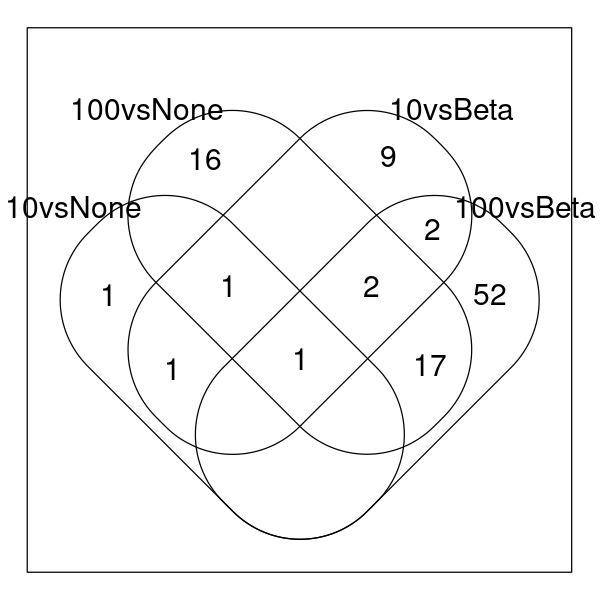

In [100]:
venn_data <- sumstats_join %>%
    filter(sig == "sig") %>%
    mutate(id = paste0(pos, "_", aa))

coefs_partial_lof_venn <- list("10vsNone" = venn_data %>%
                                   filter(condition == "IFNalpha10 - None0") %>%
                                   select(id) %>%
                                   unlist(),
                               "100vsNone" = venn_data %>%
                                   filter(condition == "IFNalpha100 - None0") %>%
                                   select(id) %>%
                                   unlist(),
                               "10vsBeta" = venn_data %>%
                                   filter(condition == "IFNalpha10 - IFNbeta100") %>%
                                   select(id) %>%
                                   unlist(),
                               "100vsBeta" = venn_data %>%
                                   filter(condition == "IFNalpha100 - IFNbeta100") %>%
                                   select(id) %>%
                                   unlist())
       
options(repr.plot.width = 5, repr.plot.height = 5)
venn(coefs_partial_lof_venn, plotsize = 5, ilcs = 1.5, sncs = 1.5)

We can examine the relationship between partial LoF called in either of the IFNalpha100 conditions directly:

In [60]:
variants <- unique(c(coefs_partial_lof_venn$`100vsNone`,
                     coefs_partial_lof_venn$`100vsBeta`))

sumstats_varsub <- sumstats_join %>%
    filter(condition %in% c("IFNalpha100 - None0", "IFNalpha100 - IFNbeta100")) %>%
    mutate(id = paste0(pos, "_", aa)) %>%
    filter(id %in% variants)

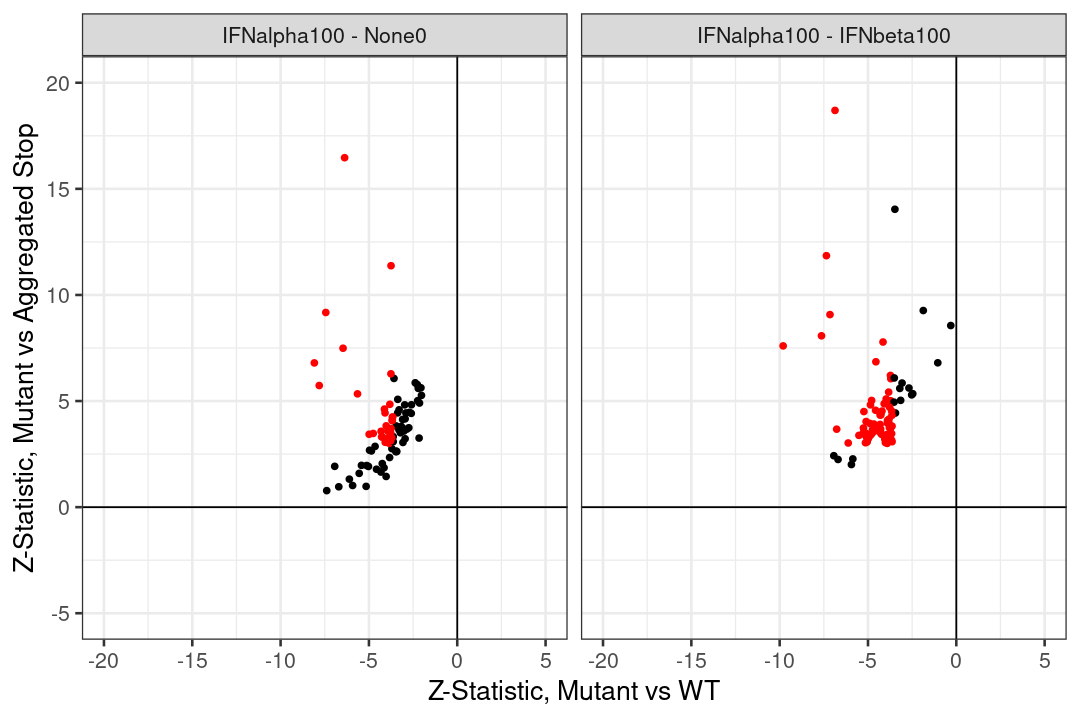

In [67]:
options(repr.plot.width = 9, repr.plot.height = 6)
ggplot(sumstats_varsub) +
    geom_point(aes(x = statistic.x, y = statistic,
                   color = if_else(sig == "sig", "red", "black"))) +
    theme_bw(base_size = 16) +
    xlab("Z-Statistic, Mutant vs WT") +
    ylab("Z-Statistic, Mutant vs Aggregated Stop") +
    xlim(c(-20,5)) + ylim(c(-5,20)) +
    geom_hline(yintercept = 0) +
    geom_vline(xintercept = 0) +
    facet_wrap(~condition) +
    scale_color_identity()

There are thresholding effects - all variants which are significantly partial LoF in one of the above two conditions are also in the correct directions in the other condition, just not necessairly strongly enough to be significant.

#### Comparison to mini-DMS

We performed the same analysis on the first mini-DMS, so we can make the same comparison we did above for the two conditions. We extract all variants that were significantly partial LoF in one or the other (or both), and then plot their Z-scores for WT and Stop effects:

In [138]:
minidms <- read_tsv("../sumstats/TYK2/run1/TYK2-Chunk10-PartialLoF.tsv") %>%
    mutate(id = paste0(pos, aa),
           sig = if_else(fdr_MutVsWt < 0.01 &
                         fdr_MutVsStop < 0.01 &
                         statistic_MutVsWt < 0 &
                         statistic_MutVsStop > 0, "sig", "nonsig"))

fulldms <- read_tsv("../sumstats/tyk2_full_comparisons_stopagg_partialLoF.tsv") %>%
    filter(chunk == 10) %>%
    mutate(id = paste0(pos, aa),
           sig = if_else(p.adj_MutVsWt < 0.01 &
                         p.adj_MutVsStop < 0.01 &
                         statistic_MutVsWt < 0 &
                         statistic_MutVsStop > 0, "sig", "nonsig"))  %>%
    mutate(condition = factor(condition,
                              levels = c("IFNbeta100 - None0",
                                         "IFNalpha1 - None0",
                                         "IFNalpha10 - None0",
                                         "IFNalpha100 - None0",
                                         "IFNalphaWithDrug100 - None0",
                                         "None0 - IFNbeta100",
                                         "IFNalpha1 - IFNbeta100",
                                         "IFNalpha10 - IFNbeta100",
                                         "IFNalpha100 - IFNbeta100",
                                         "IFNalphaWithDrug100 - IFNbeta100")))

minisig <- minidms %>% filter(sig == "sig") %>% select(id) %>% distinct() %>% unlist()
fullsig <- fulldms %>% filter(sig == "sig") %>% select(id) %>% distinct() %>% unlist()
                              
allsig <- c(minisig, fullsig)

Rows: 2660 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (2): clone, aa
dbl (12): pos, chunk, log2FC_MutVsWt, std.error_MutVsWt, statistic_MutVsWt, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 224660 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (4): clone, chunk, aa, condition
dbl (11): pos, log2FoldChange_MutVsWt, std.error_MutVsWt, statistic_MutVsWt,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


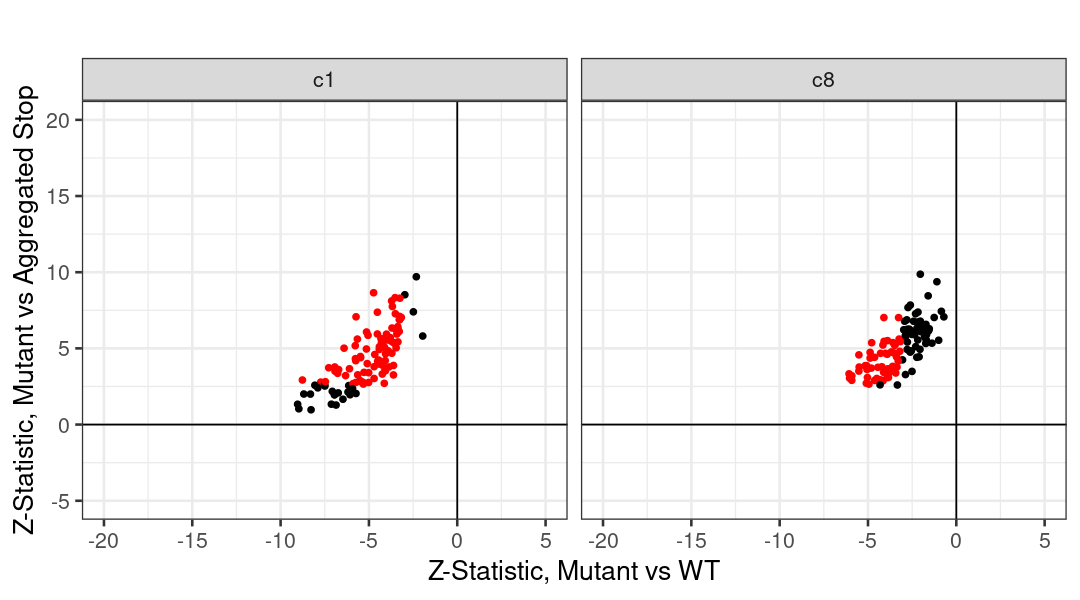

In [139]:
options(repr.plot.width = 9, repr.plot.height = 5)
ggplot(minidms %>% filter(id %in% allsig)) +
    geom_point(aes(x = statistic_MutVsWt, y = statistic_MutVsStop,
                   color = if_else(sig == "sig", "red", "black"))) +
    theme_bw(base_size = 16) +
    xlab("Z-Statistic, Mutant vs WT") +
    ylab("Z-Statistic, Mutant vs Aggregated Stop") +
    xlim(c(-20,5)) + ylim(c(-5,20)) +
    geom_hline(yintercept = 0) +
    geom_vline(xintercept = 0) +
    scale_color_identity() + 
    facet_wrap(~clone) +
    ggtitle("")

The above plot shows that all partial LoF variants identified in the full length assay (in chunk 10) are directionally consistent with the original mini-DMS, though not always significant in the mini-DMS. We can check the reverse too - that significant partial LoF variants in the mini-DMS are directionally consistent in the new data, and it looks like they indeed are (with a few exceptions):

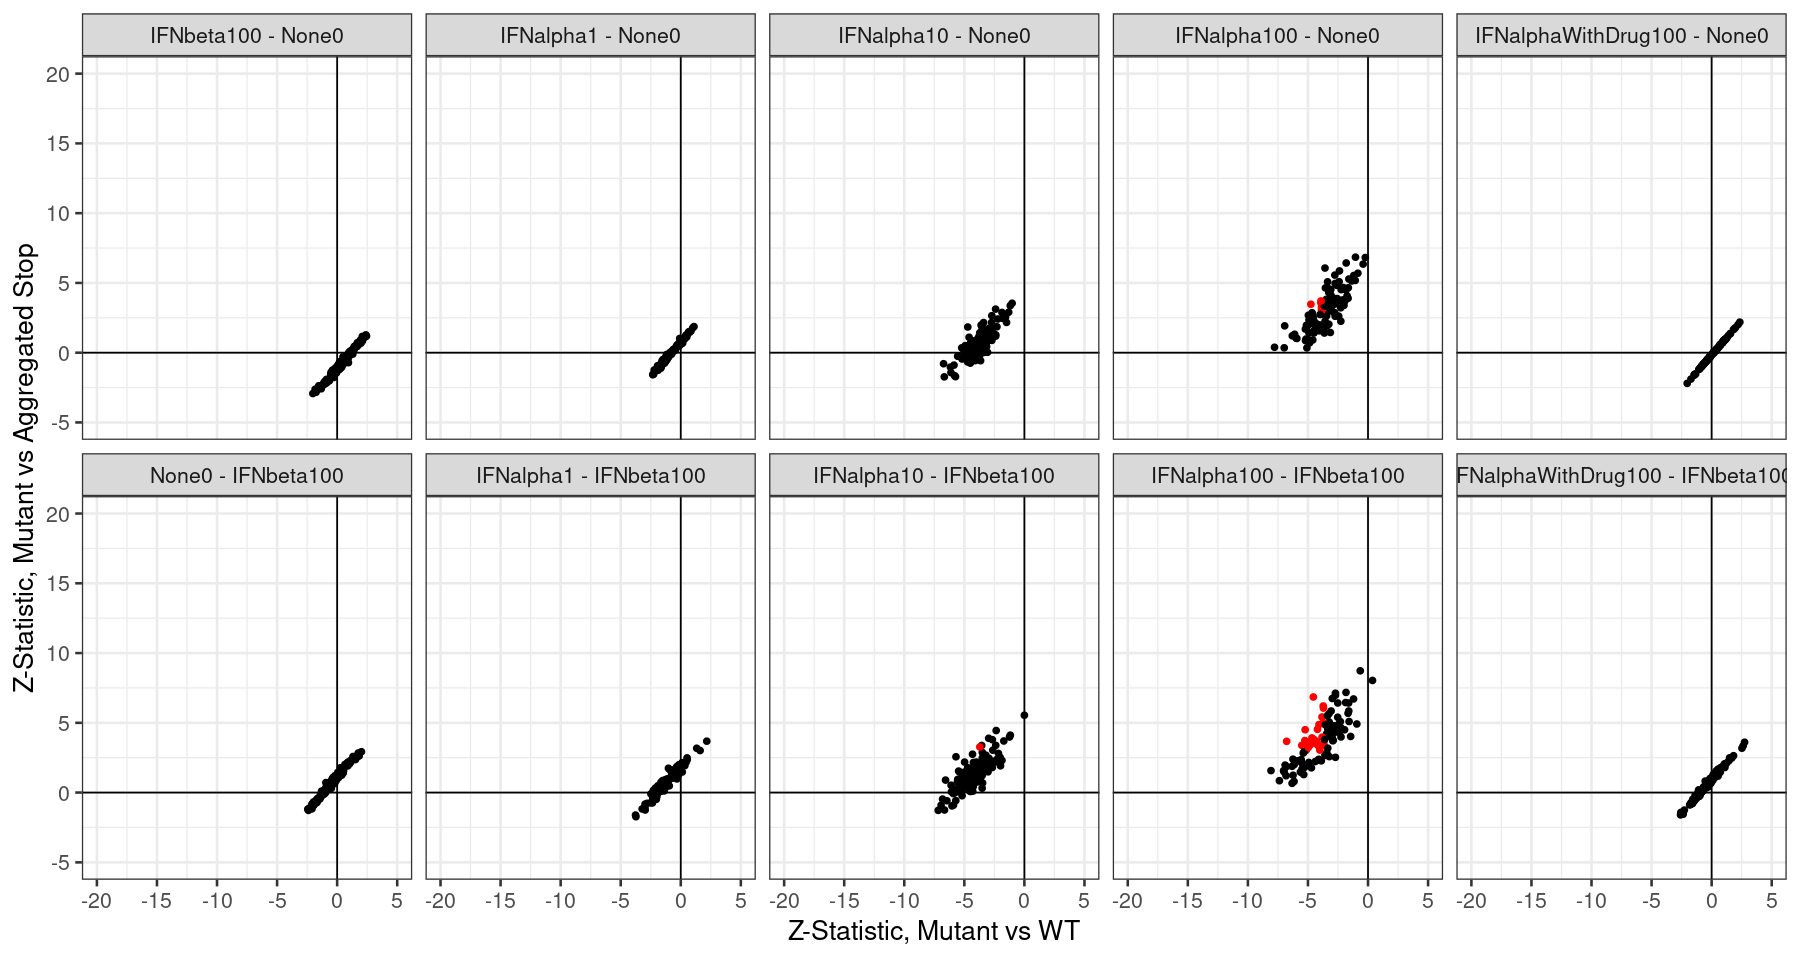

In [140]:
options(repr.plot.width = 15, repr.plot.height = 8)
ggplot(fulldms %>% filter(id %in% allsig)) +
    geom_point(aes(x = statistic_MutVsWt, y = statistic_MutVsStop,
                   color = if_else(sig == "sig", "red", "black"))) +
    theme_bw(base_size = 16) +
    xlab("Z-Statistic, Mutant vs WT") +
    ylab("Z-Statistic, Mutant vs Aggregated Stop") +
    xlim(c(-20,5)) + ylim(c(-5,20)) +
    geom_hline(yintercept = 0) +
    geom_vline(xintercept = 0) +
    scale_color_identity() +
    facet_wrap(~condition, nrow = 2)